In [2]:
import sys
sys.path.append('../')

import numpy as np
from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v
from scipy import stats


import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import scienceplots
from tensorflow.python.client import device_lib

plt.rcParams['figure.figsize'] = [10,10]

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16

from tensorflow.nn import depthwise_conv2d
from tensorflow.math import multiply, reduce_sum, reduce_mean,reduce_euclidean_norm, sin, cos, abs, reduce_variance, reduce_min, reduce_max
from tensorflow import stack, concat, expand_dims

import tensorflow_probability as tfp

from utils.utils import *


plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '300'})

#### Experiment #1 : $\beta$ accross all layers (Top-10% filters)

In [3]:
model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

In [4]:
k = 10 # Top 10% highest l2-magnitude filters

In [5]:
def get_F_angle(F):
    
    F = tf.expand_dims(F, -1)
    _, a = getSymAntiSymTF(F)
    a_mag = reduce_euclidean_norm(a, axis=[0,1])[:, 0]

    theta = getSobelTF(F)[:, 0]
    #print(a_mag.shape)
    x =a_mag*np.cos((theta))
    y = a_mag*np.sin((theta))


    cov = np.cov([x,y])
    e_val, e_vec = np.linalg.eig(cov)
    e_vec = e_vec[:, np.argmax(e_val)]
    e_val = np.max(e_val)
    if np.sign(e_vec[0]) != np.sign(x[np.argmax(np.abs(x))]):
        e_vec *= -1
    #print(e_val, e_vec)

    return np.arctan2(e_vec[1], e_vec[0])

In [6]:
def rejection_sampling(X, Y, n_samples ):
    from scipy.stats import gaussian_kde


    # Range of X
    X_min, X_max = 0, 1

    # Estimate the empirical density of X using KDE
    kde = gaussian_kde(X)
    proposal_density = kde(X)

    # Target is uniform, so the density is constant over the range
    target_density = np.ones_like(X) / (X_max - X_min)

    # Calculate importance weights
    weights = target_density / proposal_density

    # Normalize weights
    weights /= np.sum(weights)

    # Resample based on the weights
    idx = np.random.choice(np.arange(len(X)), size=n_samples, p=weights)
    print(idx)
    return np.array(X)[idx], np.array(Y)[idx]

[2, 254, 252, 14, 87, 236, 133, 85, 172, 41, 77, 130, 203, 214, 15, 79, 211, 222, 127, 17, 88, 207, 59, 34, 132, 156, 143, 99, 157, 170, 184, 86, 11, 200, 129, 210, 155, 159, 97, 50, 206, 227, 189, 168, 12, 160, 126, 27, 18, 208, 111, 191, 56, 245, 45, 84, 101, 212, 148, 83, 201, 23, 179, 161, 153, 35, 177, 22, 243, 187, 219, 29, 164, 94, 32, 66, 33, 76, 193, 46, 91, 194, 162, 216, 107, 119, 118, 60, 224, 246, 244, 31, 248, 103, 223, 93, 55, 238, 138, 5, 95, 109, 250, 176, 25, 116, 124, 26, 80, 197, 169, 43, 251, 0, 115, 141, 104, 166, 221, 232, 51, 131, 145, 136, 72, 105, 158, 230, 228, 142, 7, 75, 231, 163, 20, 249, 137, 98, 247, 70, 62, 30, 239, 1, 125, 38, 217, 52, 182, 196, 154, 122, 128, 183, 146, 40, 192, 3, 198, 213, 240, 205, 28, 229, 63, 65, 218, 68, 144, 204, 225, 108, 112, 147, 19, 151, 39, 81, 73, 241, 215, 9, 16, 195, 21, 4, 220, 69, 235, 185, 175, 90, 253, 134, 114, 89, 6, 120, 78, 178, 53, 226, 202, 36, 181, 237, 100, 234, 152, 242, 188, 139, 180, 150, 167, 209, 135, 92

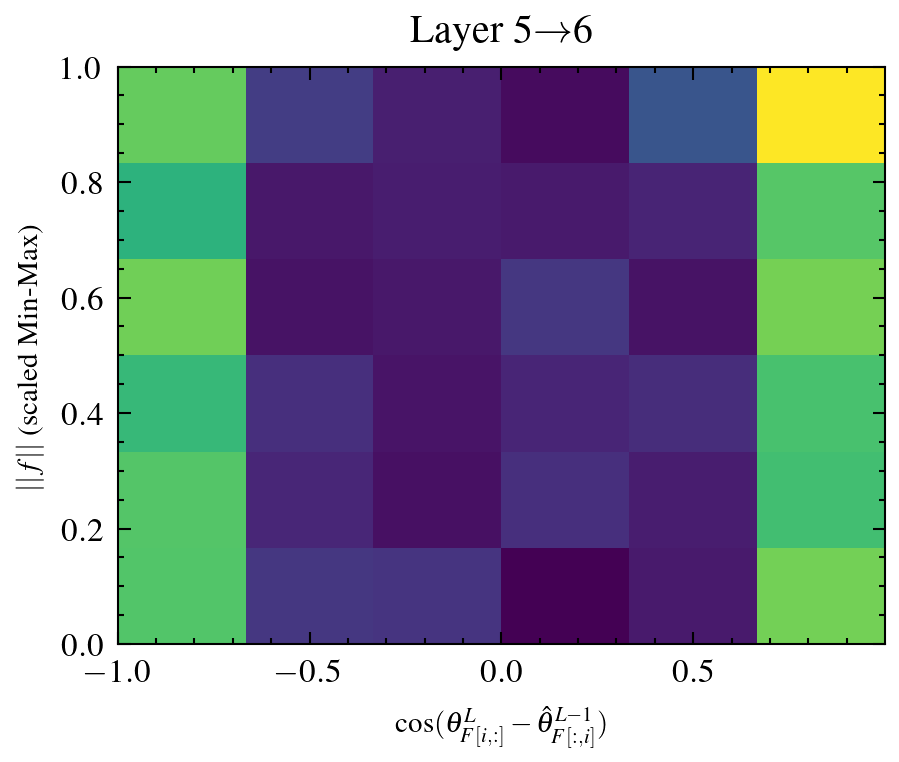

In [16]:
conv_layers = []
for l in model.layers:
    if 'conv2d' in str(type(l)).lower():
        if l.kernel_size == (3,3):
            conv_layers.append(l)


l_num = 5
top10Fprev=topKfilters(model, l_num-1, k=1000)
print(top10Fprev)
filtersLprev = get_filter(model, l_num-1)[:,:,:, top10Fprev]
top10F=topKfilters(model, l_num, k=100)
filtersL = get_filter(model, l_num)[:,:,: , top10F]
filtersL = filtersL[:, :, top10Fprev, :]


print("FL", filtersL.shape)

# Get kernels magnitude and theta for layer L
s, a = getSymAntiSymTF(filtersL)
mag = reduce_euclidean_norm(a+s, axis=[0,1])
theta = getSobelTF(filtersL)
 
mag = (mag - reduce_min(mag, axis=0))/(reduce_max(mag, axis=0) - reduce_min(mag, axis=0))

print("AMAG", mag.shape)


#find lims :
cos_sim = []
m = []

for i in range(filtersLprev.shape[-1]):
    
    theta_F_prev = get_F_angle(filtersLprev[:,:,:,i])
    cos_sim.extend((np.cos(theta_F_prev - theta[:, i])))
    m.extend(mag[:, i].numpy())

print("M", len(m))
m, t= rejection_sampling(m, cos_sim, 5000)
print(cos_sim)
#fig.subplots_adjust(left=None, bottom=None, right=0.005, top=0.005)

fig, ax= plt.subplots(1,1)

ax.hist2d(t, m, bins=6)
ax.set_ylabel(r"$||f||$ (scaled Min-Max)", fontsize=7)
#ax.set_ylabel(r"Count", fontsize=7)
ax.set_xlabel(r"$\cos(\mathbf{\theta}^{L}_{F[i, :]} - \hat{\theta}^{L-1}_{F[:, i]})$", fontsize=7)
ax.set_title(f"Layer {l_num}"+r"$\rightarrow$"+f"{l_num+1}")


plt.show() 


(array([1., 6., 3., 2., 3., 5., 4., 1., 4., 3.]),
 array([0.04293392, 0.13864052, 0.23434713, 0.33005375, 0.42576036,
        0.521467  , 0.61717355, 0.7128802 , 0.8085868 , 0.9042934 ,
        1.        ], dtype=float32),
 <BarContainer object of 10 artists>)

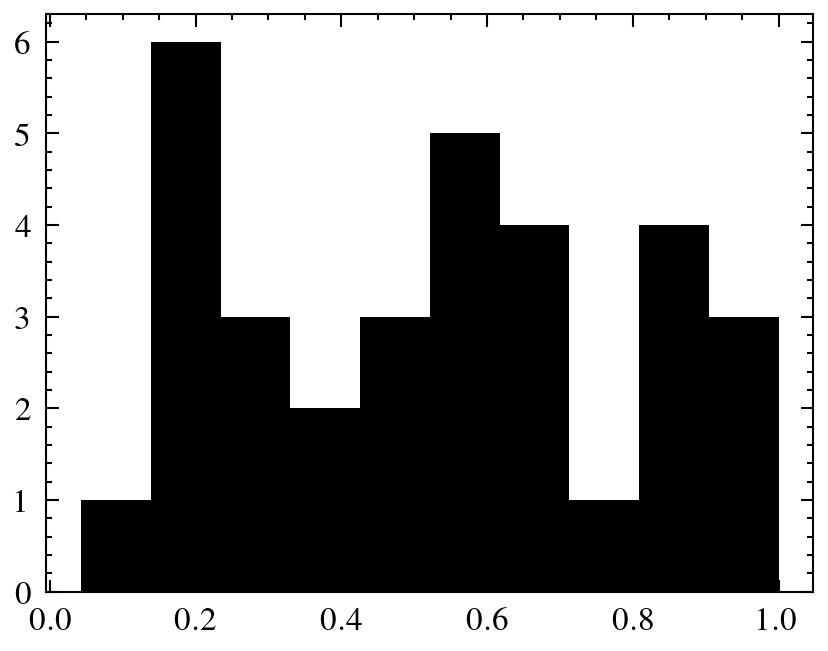

In [8]:
plt.hist(m)

In [9]:
reduce_variance(filters, axis=None)

NameError: name 'filters' is not defined

In [ ]:
fig.subplots_adjust(wspace=0.025, hspace=0.025)
plt.show()

NameError: name 'fig' is not defined

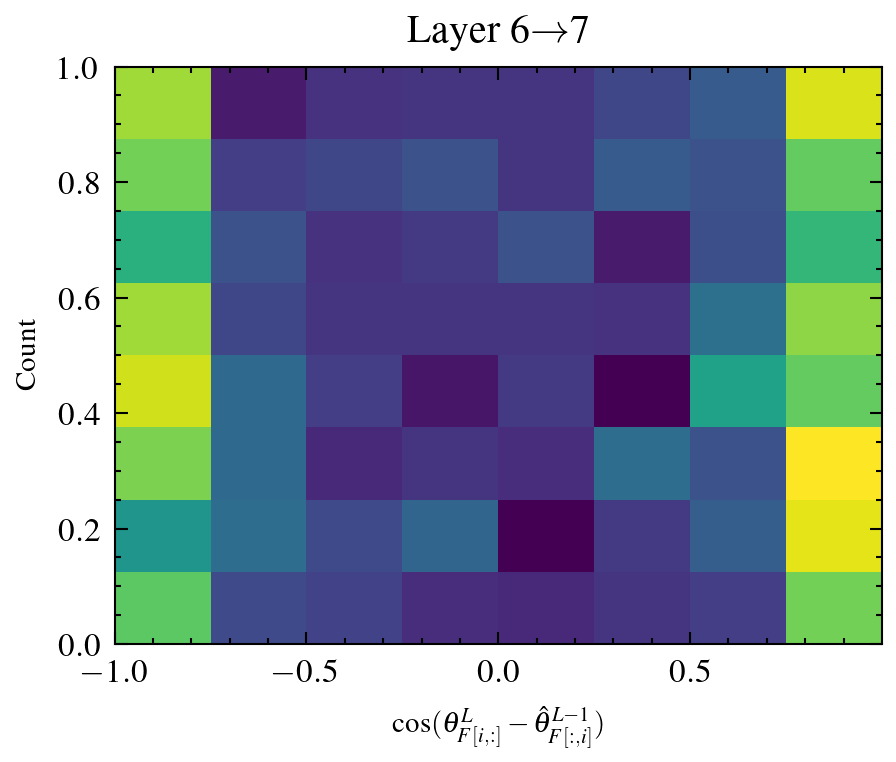

In [ ]:
fig, ax= plt.subplots(1,1)
ax.hist2d(t, m, bins=8)
#ax.set_ylabel(r"$||f||$ (scaled Min-Max)", fontsize=7)
ax.set_ylabel(r"Count", fontsize=7)
ax.set_xlabel(r"$\cos(\mathbf{\theta}^{L}_{F[i, :]} - \hat{\theta}^{L-1}_{F[:, i]})$", fontsize=7)
ax.set_title(f"Layer {l_num}"+r"$\rightarrow$"+f"{l_num+1}")


plt.show() 
